In [2]:
from sklearn.datasets import load_files
import pandas as pd
import spacy
import re
import numpy as np
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

random_state = 0

In [3]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import matplotlib
from nltk.corpus import stopwords, wordnet
import nltk
from textblob import Word
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [4]:
#Setting plot parameters
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'



In [5]:
# Importing the database 
df = pd.read_csv("SO_CI_Tag_Final.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12628 entries, 0 to 12627
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             12628 non-null  int64  
 1   Body           12628 non-null  object 
 2   Title          12628 non-null  object 
 3   CreationDate   12628 non-null  object 
 4   Score          12628 non-null  int64  
 5   ViewCount      12628 non-null  int64  
 6   Tags           12628 non-null  object 
 7   AnswerCount    12628 non-null  int64  
 8   FavoriteCount  3794 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 888.0+ KB


In [7]:
# Check missing values in FavoriteCount
df['FavoriteCount'].value_counts(dropna=False).sort_index(ascending=False)
# Fill the missing values with 0
df["FavoriteCount"].fillna(0,inplace = True)
# Check the changes
df['FavoriteCount'].value_counts(dropna=False).sort_index(ascending=False)

222.0       1
203.0       1
133.0       1
111.0       1
108.0       2
         ... 
4.0       160
3.0       290
2.0       615
1.0      1973
0.0      9141
Name: FavoriteCount, Length: 61, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12628 entries, 0 to 12627
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             12628 non-null  int64  
 1   Body           12628 non-null  object 
 2   Title          12628 non-null  object 
 3   CreationDate   12628 non-null  object 
 4   Score          12628 non-null  int64  
 5   ViewCount      12628 non-null  int64  
 6   Tags           12628 non-null  object 
 7   AnswerCount    12628 non-null  int64  
 8   FavoriteCount  12628 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 888.0+ KB


In [9]:
df[["CreationDate"]] = df[["CreationDate"]].apply(pd.to_datetime)

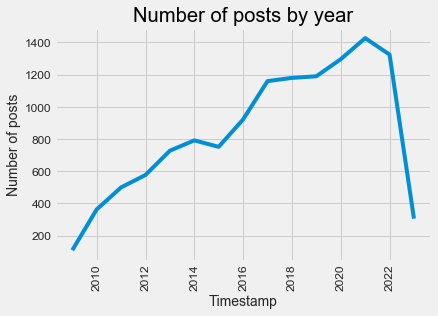

In [10]:


#Calculating number of tweets by hour
count_by_year = df.groupby(pd.Grouper(key='CreationDate', freq="1Y")).count()
#Plotting time series graph for tweets
plt.plot(count_by_year['Id'])
plt.xlabel('Timestamp')
plt.ylabel('Number of posts')
plt.xticks(rotation=90)
plt.title('Number of posts by year')
plt.show()



In [11]:
import re

def purge_tags(v):
    regex = re.findall(r'\<(.*?)\>',v)
    new_tags = " ".join(x for x in regex)
    
    return new_tags

In [12]:
df['Tags_f'] = df.Tags
df['Tags_f'] = df["Tags_f"].apply(purge_tags)

In [13]:
df.head(5)

Id                                               Body  \
0  71542507  <p>I'm very new to E2E test, cypress and gitla...   
1  71540887  <p>I'm trying to make CI pipeline and run phpu...   
2  71538291  <p>After automating my GitLab CI deployment, I...   
3  71534731  <p>I am using the gitlab as my CI/CD system. A...   
4  71533027  <p>I'm trying to build a Godot mono project th...   

                                               Title        CreationDate  \
0  Cypress - How do I change URL for gitlab ci pi... 2022-03-19 22:12:44   
1  Laravel + phpunit + github actions = Failed as... 2022-03-19 18:22:51   
2      Using GitLab VirtualBox executor without GUI? 2022-03-19 12:52:28   
3  How to skip job in gitlab-ci.yml base on diffe... 2022-03-19 01:36:51   
4  Can't build Godot mono project "namespace name... 2022-03-18 20:48:11   

   Score  ViewCount                                               Tags  \
0      0          6  <gitlab><continuous-integration><cypress><e2e-...   
1      0         11  <laravel><testing><continuous-integration><php...   
2      0         11  <gitlab><continuous-integration><virtualbox><e...   
3      0         23   <gitlab><continuous-integration><cross-platform>   
4      0         11              <continuous-integration><mono><godot>   

   AnswerCount  FavoriteCount  \
0            0            0.0   
1            0            0.0   
2            0            0.0   
3            2            0.0   
4            1            0.0   

                                              Tags_f  
0  gitlab continuous-integration cypress e2e-testing  
1  laravel testing continuous-integration phpunit...  
2  gitlab continuous-integration virtualbox execu...  
3       gitlab continuous-integration cross-platform  
4                  continuous-integration mono godot

In [14]:


# NLTK Stop words
from nltk.corpus import stopwords

import nltk; nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu'])



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\11shr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Convert to list
data = df.Title.values.tolist()
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['cypress', 'how', 'do', 'change', 'url', 'for', 'gitlab', 'ci', 'pipeline']]


In [17]:
# Convert to list
body = df.Body.values.tolist()
# Remove new line characters
body = [re.sub('\s+', ' ', sent) for sent in body]

# Remove distracting single quotes
body = [re.sub("\'", "", sent) for sent in body]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

body_words = list(sent_to_words(body))

print(body_words[:1])

[['im', 'very', 'new', 'to', 'test', 'cypress', 'and', 'gitlab', 'ci', 'my', 'idea', 'is', 'to', 'run', 'cypress', 'test', 'before', 'each', 'merge', 'but', 'dont', 'know', 'how', 'to', 'change', 'the', 'url', 'that', 'im', 'testing', 'when', 'run', 'pipeline', 'on', 'gitlab', 'lets', 'say', 'this', 'is', 'my', 'first', 'test', 'pre', 'code', 'it', 'exibicao', 'de', 'modal', 'no', 'clique', 'do', 'botao', 'gt', 'cy', 'visit', 'http', 'cy', 'get', 'inner', 'header', 'pt', 'header', 'click', 'cy', 'get', 'modal', 'login', 'should', 'be', 'visible', 'code', 'pre', 'for', 'my', 'local', 'environment', 'im', 'using', 'the', 'url', 'href', 'http', 'rel', 'nofollow', 'noreferrer', 'http', 'how', 'do', 'change', 'to', 'the', 'right', 'url', 'when', 'run', 'this', 'test', 'on', 'gitlab', 'ci', 'pipeline', 'any', 'help']]


In [18]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

In [20]:
# Build the bigram model
bigram_body = gensim.models.Phrases(body_words, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a bigram
bigram_mod_body = gensim.models.phrases.Phraser(bigram_body)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

In [21]:
print(bigram_mod[data_words[0]])

['cypress', 'how', 'do', 'change', 'url', 'for', 'gitlab', 'ci', 'pipeline']


In [22]:
print(bigram_mod_body[body_words[0]])

['im', 'very', 'new', 'to', 'test', 'cypress', 'and', 'gitlab', 'ci', 'my', 'idea', 'is', 'to', 'run', 'cypress', 'test', 'before', 'each', 'merge', 'but', 'dont', 'know', 'how', 'to', 'change', 'the', 'url', 'that', 'im', 'testing', 'when', 'run', 'pipeline', 'on', 'gitlab', 'lets_say', 'this', 'is', 'my', 'first', 'test', 'pre', 'code', 'it', 'exibicao', 'de', 'modal', 'no', 'clique', 'do', 'botao', 'gt', 'cy_visit', 'http', 'cy', 'get', 'inner', 'header', 'pt', 'header', 'click', 'cy', 'get', 'modal', 'login', 'should', 'be', 'visible', 'code', 'pre', 'for', 'my', 'local', 'environment', 'im', 'using', 'the', 'url', 'href', 'http', 'rel', 'nofollow', 'noreferrer', 'http', 'how', 'do', 'change', 'to', 'the', 'right', 'url', 'when', 'run', 'this', 'test', 'on', 'gitlab', 'ci', 'pipeline', 'any', 'help']


In [23]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# from nltk.stem.porter import *
# p_stemmer = PorterStemmer()

def remove_stopwords(texts):
    #return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    return [[word for word in doc if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        #texts_out.append([p_stemmer.stem(token.lemma_) for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
#data_words_bigrams = make_trigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



In [25]:


# Remove Stop Words
body_words_nostops = remove_stopwords(body_words)

# Form Bigrams
body_words_bigrams = make_bigrams(body_words_nostops)
#data_words_bigrams = make_trigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
body_lemmatized = lemmatization(body_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



In [26]:
print(data_lemmatized[:1])

[['pipeline']]


In [27]:
print(body_lemmatized[:1])

[['m', 'new', 'test', 'cypress', 'ci', 'idea', 'run', 'cypress', 'test', 'merge', 'know', 'change', 'm', 'test', 'run', 'pipeline', 'first', 'test', 'pre', 'code', 'exibicao', 'get', 'inner', 'header', 'header', 'click', 'get', 'modal', 'login', 'visible', 'code', 'pre', 'local', 'environment', 'm', 'use', 'noreferrer', 'http', 'change', 'right', 'url', 'run', 'test', 'help']]


In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [29]:
# Create Dictionary
id2word_body = corpora.Dictionary(body_lemmatized)

texts_body = body_lemmatized

# Term Document Frequency
corpus_body = [id2word_body.doc2bow(text) for text in texts]

# View
print(corpus_body[:1])

[[(22, 1)]]


In [30]:


[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]



[[('pipeline', 1)]]

In [ ]:
# -----------------------------------------------------------------------------------

In [34]:


post = df[["Body", "Title", "Tags"]]



In [35]:
post.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12628 entries, 0 to 12627
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    12628 non-null  object
 1   Title   12628 non-null  object
 2   Tags    12628 non-null  object
dtypes: object(3)
memory usage: 296.1+ KB


In [36]:
duplicates = post[post.Body.map(post.Body.value_counts() > 1)]
duplicates.sort_values('Body')[['Body', 'Title']]

Empty DataFrame
Columns: [Body, Title]
Index: []

In [37]:


post.isnull().sum().sort_values(ascending=False) / post.shape[0] * 100



Body     0.0
Title    0.0
Tags     0.0
dtype: float64

In [38]:
post["Full_Post"] = np.where(post["Title"].isna(),post["Body"] , post["Title"] + " " + post["Body"])




C:\Users\11shr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
post.head(5)

Body  \
0  <p>I'm very new to E2E test, cypress and gitla...   
1  <p>I'm trying to make CI pipeline and run phpu...   
2  <p>After automating my GitLab CI deployment, I...   
3  <p>I am using the gitlab as my CI/CD system. A...   
4  <p>I'm trying to build a Godot mono project th...   

                                               Title  \
0  Cypress - How do I change URL for gitlab ci pi...   
1  Laravel + phpunit + github actions = Failed as...   
2      Using GitLab VirtualBox executor without GUI?   
3  How to skip job in gitlab-ci.yml base on diffe...   
4  Can't build Godot mono project "namespace name...   

                                                Tags  \
0  <gitlab><continuous-integration><cypress><e2e-...   
1  <laravel><testing><continuous-integration><php...   
2  <gitlab><continuous-integration><virtualbox><e...   
3   <gitlab><continuous-integration><cross-platform>   
4              <continuous-integration><mono><godot>   

                                           Full_Post  
0  Cypress - How do I change URL for gitlab ci pi...  
1  Laravel + phpunit + github actions = Failed as...  
2  Using GitLab VirtualBox executor without GUI? ...  
3  How to skip job in gitlab-ci.yml base on diffe...  
4  Can't build Godot mono project "namespace name...

In [40]:
questions = post["Full_Post"]

In [41]:
questions

0        Cypress - How do I change URL for gitlab ci pi...
1        Laravel + phpunit + github actions = Failed as...
2        Using GitLab VirtualBox executor without GUI? ...
3        How to skip job in gitlab-ci.yml base on diffe...
4        Can't build Godot mono project "namespace name...
                               ...                        
12623    Running xinc on OpenBSD's Apache Server <p>Has...
12624    Pre-build task - deleting the working copy in ...
12625    Setting up Continuous Integration with SVN <p>...
12626    Integrating Visual Studio Test Project with Cr...
12627    Continuous Integration System for a Python Cod...
Name: Full_Post, Length: 12628, dtype: object

In [42]:
import nltk
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize

In [43]:
def clean_code(post):
    for i in range(len(questions)):
        questions[i]=str(questions[i]).replace(str(BeautifulSoup(questions[i]).find("code")), "")
        questions[i]= BeautifulSoup(questions[i]).get_text()

In [44]:


liste_p = questions.tolist()



In [45]:
liste_p

['Cypress - How do I change URL for gitlab ci pipeline? <p>I\'m very new to E2E test, cypress and gitlab ci. My idea is to run cypress test before each merge. But I don\'t know how to change the URL that I\'m testing when I run a pipeline on gitlab. Let\'s say this is my first test:</p>\n<pre><code>it(\'Exibição de modal no clique do botão\', () =&gt; {\n        cy.visit(\'http://127.0.0.1:8000\');\n        cy.get(\'.inner-header-pt2 .header-buttons__cadastro\').click();\n        cy.get(\'.modal--login\').should(\'be.visible\');\n})\n</code></pre>\n<p>For my local environment, I\'m using the URL <a href="http://127.0.0.1:8000" rel="nofollow noreferrer">http://127.0.0.1:8000</a>. How do I change to the right URL when I run this test on gitlab ci pipeline? Any help?</p>\n',
 'Laravel + phpunit + github actions = Failed asserting that \'1\' is identical to 1 <p>I\'m trying to make CI pipeline and run phpunit tests via GitHub actions.<br />\nFirst of all: tests work fine on my local machin

In [46]:


clean_code(liste_p)



C:\Users\11shr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\11shr\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [47]:
liste_p

['Cypress - How do I change URL for gitlab ci pipeline? <p>I\'m very new to E2E test, cypress and gitlab ci. My idea is to run cypress test before each merge. But I don\'t know how to change the URL that I\'m testing when I run a pipeline on gitlab. Let\'s say this is my first test:</p>\n<pre><code>it(\'Exibição de modal no clique do botão\', () =&gt; {\n        cy.visit(\'http://127.0.0.1:8000\');\n        cy.get(\'.inner-header-pt2 .header-buttons__cadastro\').click();\n        cy.get(\'.modal--login\').should(\'be.visible\');\n})\n</code></pre>\n<p>For my local environment, I\'m using the URL <a href="http://127.0.0.1:8000" rel="nofollow noreferrer">http://127.0.0.1:8000</a>. How do I change to the right URL when I run this test on gitlab ci pipeline? Any help?</p>\n',
 'Laravel + phpunit + github actions = Failed asserting that \'1\' is identical to 1 <p>I\'m trying to make CI pipeline and run phpunit tests via GitHub actions.<br />\nFirst of all: tests work fine on my local machin

In [48]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['need','think','way','want','problem','think','question',
                   'answer','use','ii','change','help','would',"write",'check','sure','error','exists','work','thing','like','look',
                  "something", "could","simple","might" ,"along", "though","guess", "course" ,"anything","one","another","two","lot",
                  "simple","language","code","garbage","either","wait","foo","idea","org","solution","found"])

In [49]:


from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize with POS Tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)



In [50]:


def tokenize_list(liste_p):

    new_list = list()
    freq =  nltk.FreqDist()
    
    for i in range(len(liste_p)):
        
        new_list.append([lemmatizer.lemmatize(w.lower(),get_wordnet_pos(w.lower())) 
                                      for w in tokenizer.tokenize(liste_p[i]) if not w.lower() in stop_words and str.isalpha(w)== True and
                         get_wordnet_pos(w.lower())=="n"])
        
        freq += nltk.FreqDist(new_list[i])
        
    return new_list, freq



In [53]:
questions

0        Cypress - How do I change URL for gitlab ci pi...
1        Laravel + phpunit + github actions = Failed as...
2        Using GitLab VirtualBox executor without GUI? ...
3        How to skip job in gitlab-ci.yml base on diffe...
4        Can't build Godot mono project "namespace name...
                               ...                        
12623    Running xinc on OpenBSD's Apache Server Has an...
12624    Pre-build task - deleting the working copy in ...
12625    Setting up Continuous Integration with SVN Wha...
12626    Integrating Visual Studio Test Project with Cr...
12627    Continuous Integration System for a Python Cod...
Name: Full_Post, Length: 12628, dtype: object

In [83]:
#Cleaning Text - strip HTML
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
def remove_r(text):
    text = text.replace('\r', '')
    return text
def remove_n(text):
    text = text.replace('\n', '')
    return text
def remove_email(text):
    text = ' '.join([item for item in text.split() if '@' not in item])
    return text

#Expanding Contractions
def expand_contractions(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
#Removing Special Characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text
#Lemmatizing text
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


In [56]:
#Removing Stopwords
# These words are important for our problem. We don't want to remove them.
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop_words = [word for word in stopword_list]

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens if token not in excluding]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
    


In [85]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     text_lower_case=False, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_r_f=True, remove_n_f=True, remove_emails=True):
    
    normalized_corpus = []
    
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        if remove_r_f:
            doc = remove_r(doc)
        if remove_n_f:
            doc = remove_n(doc)
        if remove_emails:
            doc = remove_email(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        doc = re.sub('\S*@\S*\s?', '', doc)  # remove emails
        doc = re.sub('\s+', ' ', doc)  # remove newline chars
        doc = re.sub("\'", "", doc)  # remove single quotes

        #remove rn which comes from \r and \n after stripping spaces and slash (\)
        doc = doc.replace('rn', '')
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # Remove leading/trailing whitespace
        doc = re.sub('\s+', ' ', doc)
        # Removing numbers
        #doc = re.sub(r"\d+","",doc)
        # Remove URLs
        doc = re.sub(r'http\S+', '', doc) 
        # Remove extra space and tabs
        doc = re.sub('\s+', ' ', doc) 
        # Reove accronyms
        #doc = re.sub(r"\b[A-Z]{2,}\b", "", doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [60]:
question = post

In [68]:
question.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12628 entries, 0 to 12627
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Body       12628 non-null  object
 1   Title      12628 non-null  object
 2   Tags       12628 non-null  object
 3   Full_Post  12628 non-null  object
dtypes: object(4)
memory usage: 394.8+ KB


In [76]:
ques = question[['Full_Post']]

In [77]:
ques

Full_Post
0      Cypress - How do I change URL for gitlab ci pi...
1      Laravel + phpunit + github actions = Failed as...
2      Using GitLab VirtualBox executor without GUI? ...
3      How to skip job in gitlab-ci.yml base on diffe...
4      Can't build Godot mono project "namespace name...
...                                                  ...
12623  Running xinc on OpenBSD's Apache Server Has an...
12624  Pre-build task - deleting the working copy in ...
12625  Setting up Continuous Integration with SVN Wha...
12626  Integrating Visual Studio Test Project with Cr...
12627  Continuous Integration System for a Python Cod...

[12628 rows x 1 columns]

In [86]:
print("Pre-processing the description field with use of Lemmatization")
ques["Full_Post_Cleaned"] = normalize_corpus(ques["Full_Post"].tolist())

Pre-processing the description field with use of Lemmatization


C:\Users\11shr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [87]:
ques

Full_Post  \
0      Cypress - How do I change URL for gitlab ci pi...   
1      Laravel + phpunit + github actions = Failed as...   
2      Using GitLab VirtualBox executor without GUI? ...   
3      How to skip job in gitlab-ci.yml base on diffe...   
4      Can't build Godot mono project "namespace name...   
...                                                  ...   
12623  Running xinc on OpenBSD's Apache Server Has an...   
12624  Pre-build task - deleting the working copy in ...   
12625  Setting up Continuous Integration with SVN Wha...   
12626  Integrating Visual Studio Test Project with Cr...   
12627  Continuous Integration System for a Python Cod...   

                                       Full_Post_Cleaned  
0      cypress change URL gitlab ci pipeline new E2E ...  
1      laravel phpunit github action fail assert 1 id...  
2      use GitLab VirtualBox executor without GUI aut...  
3      skip job gitlab ci yml base different runner u...  
4      build Godot mono project namespace name Godot ...  
...                                                  ...  
12623  run xinc OpenBSD Apache Server anyone able get...  
12624  pre build task delete working copy CruiseContr...  
12625  set Continuous Integration SVN tool would reco...  
12626  integrate Visual Studio Test Project Cruise Co...  
12627  Continuous Integration System Python Codebase ...  

[12628 rows x 2 columns]

In [88]:
def normalize_corpus_rn(corpus):
    
    normalized_corpus_rn = []
    
    # normalize each document in the corpus
    for doc in corpus:
        doc = doc.replace('rn', '')
        # Removing numbers
        doc = re.sub(r"\d+","",doc)
        # Reove accronyms
        doc = re.sub(r"\b[A-Z]{2,}\b", "", doc)
        # Removing numbers
        doc = re.sub(r"\d+","",doc)
        normalized_corpus_rn.append(doc)
        
    return normalized_corpus_rn

In [89]:


print("Pre-processing the description field with use of Lemmatization")
ques["Full_Post_Cleaned_New"] = normalize_corpus_rn(ques["Full_Post_Cleaned"].tolist())



Pre-processing the description field with use of Lemmatization


C:\Users\11shr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [90]:
ques.head(5)

Full_Post  \
0  Cypress - How do I change URL for gitlab ci pi...   
1  Laravel + phpunit + github actions = Failed as...   
2  Using GitLab VirtualBox executor without GUI? ...   
3  How to skip job in gitlab-ci.yml base on diffe...   
4  Can't build Godot mono project "namespace name...   

                                   Full_Post_Cleaned  \
0  cypress change URL gitlab ci pipeline new E2E ...   
1  laravel phpunit github action fail assert 1 id...   
2  use GitLab VirtualBox executor without GUI aut...   
3  skip job gitlab ci yml base different runner u...   
4  build Godot mono project namespace name Godot ...   

                               Full_Post_Cleaned_New  
0  cypress change  gitlab ci pipeline new  test c...  
1  laravel phpunit github action fail assert  ide...  
2  use GitLab VirtualBox executor without  automa...  
3  skip job gitlab ci yml base different runner u...  
4  build Godot mono project namespace name Godot ...

In [91]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) # deacc=True (Removed punctuation)
        yield(sent)  

# Convert to list
data = ques.Full_Post_Cleaned_New.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['cypress', 'change', 'gitlab', 'ci', 'pipeline', 'new', 'test', 'cypress', 'gitlab', 'ci', 'idea', 'run', 'cypress', 'test', 'merge', 'know', 'change', 'url', 'test', 'run', 'pipeline', 'gitlab', 'let', 'say', 'first', 'test', 'local', 'environment', 'use', 'change', 'right', 'url', 'run', 'test', 'gitlab', 'ci', 'pipeline', 'help']]


In [92]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [93]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    #nlp = spacy.load('en-core-web-sm-2.2.0', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [95]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.114*"test" + 0.092*"integration" + 0.074*"continuous" + 0.033*"run" + '
  '0.030*"change" + 0.028*"unit" + 0.018*"commit" + 0.016*"database" + '
  '0.016*"branch" + 0.015*"good"'),
 (1,
  '0.055*"process" + 0.051*"automate" + 0.045*"like" + 0.039*"run" + '
  '0.037*"source" + 0.037*"currently" + 0.036*"server" + 0.030*"service" + '
  '0.030*"possible" + 0.027*"however"'),
 (2,
  '0.100*"build" + 0.049*"use" + 0.044*"project" + 0.030*"server" + '
  '0.023*"work" + 0.021*"code" + 0.018*"get" + 0.018*"set" + 0.014*"way" + '
  '0.013*"want"'),
 (3,
  '0.000*"itemgroup" + 0.000*"taste" + 0.000*"tangible" + 0.000*"starteam" + '
  '0.000*"chroote" + 0.000*"scon" + 0.000*"toolset" + 0.000*"thoughtwork" + '
  '0.000*"ocunit" + 0.000*"appengine"'),
 (4,
  '0.088*"file" + 0.051*"task" + 0.031*"compile" + 0.027*"folder" + '
  '0.027*"copy" + 0.026*"dependency" + 0.023*"support" + 0.023*"product" + '
  '0.022*"output" + 0.021*"generate"'),
 (5,
  '0.080*"plugin" + 0.073*"hudson" + 0.047*"

In [96]:


from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("lda_model")
lda_model.save(temp_file)



In [97]:
# Load a potentially pretrained model from disk.
lda_model = lda_model.load(temp_file)

In [99]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.7262   
1            1             2.0              0.7979   
2            2             1.0              0.7001   
3            3             7.0              0.3812   
4            4             2.0              0.9178   
5            5             7.0              0.6339   
6            6             4.0              0.4015   
7            7             2.0              0.5808   
8            8             9.0              0.3157   
9            9             2.0              0.5242   

                                            Keywords  \
0  test, integration, continuous, run, change, un...   
1  build, use, project, server, work, code, get, ...   
2  process, automate, like, run, source, currentl...   
3  script, cruisecontrol, job, execute, trigger, ...   
4  build, use, project, server, work, code, get, ...   
5  script, cruisecontrol, job, execute, trigger, ...   
6  file, task, compile, folder, copy, dependency,...   
7  build, use, project, server, work, code, get, ...   
8  tool, teamcity, system, version, need, msbuild...   
9  build, use, project, server, work, code, get, ...   

                                                Text  
0  [change, pipeline, new, test, cypress, ci, ide...  
1  [laravel, fail, assert, identical, try, make, ...  
2  [executor, installer, ci, job, interfere, inst...  
3  [job, ci, yml, base, different, runner, use, s...  
4  [build, godot, namespace, name, godot, find, b...  
5  [yml, file, ci, schedule, else, name, work, co...  
6  [remove, object, file, pipeline, create, yaml,...  
7  [unable, pass, variable, downstream, pipeline,...  
8  [variable, jenkin, need, hide, value, jenkin, ...  
9  [enable, hot, reload, application, docker, use...

In [100]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(4)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.7983   
1        1.0              0.7243   
2        2.0              0.9178   
3        4.0              0.6998   

                                                                              Keywords  \
0     test, integration, continuous, run, change, unit, commit, database, branch, good   
1  process, automate, like, run, source, currently, server, service, possible, however   
2                         build, use, project, server, work, code, get, set, way, want   
3    file, task, compile, folder, copy, dependency, support, product, output, generate   

                                                                                   Representative Text  
0  [way, pre, run, test, merge, commit, branch, merge, merge, automatically, run, test, feature, br...  
1  [run, command, docker, image, build, docker, image, runner, docker, late, image, push, image, re...  
2  [build, godot, namespace, name, godot, find, build, godot, mono, project, clone, work, machine, ...  
3                                                                                     [portal, portal]

In [102]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

In [ ]:
doc_lens

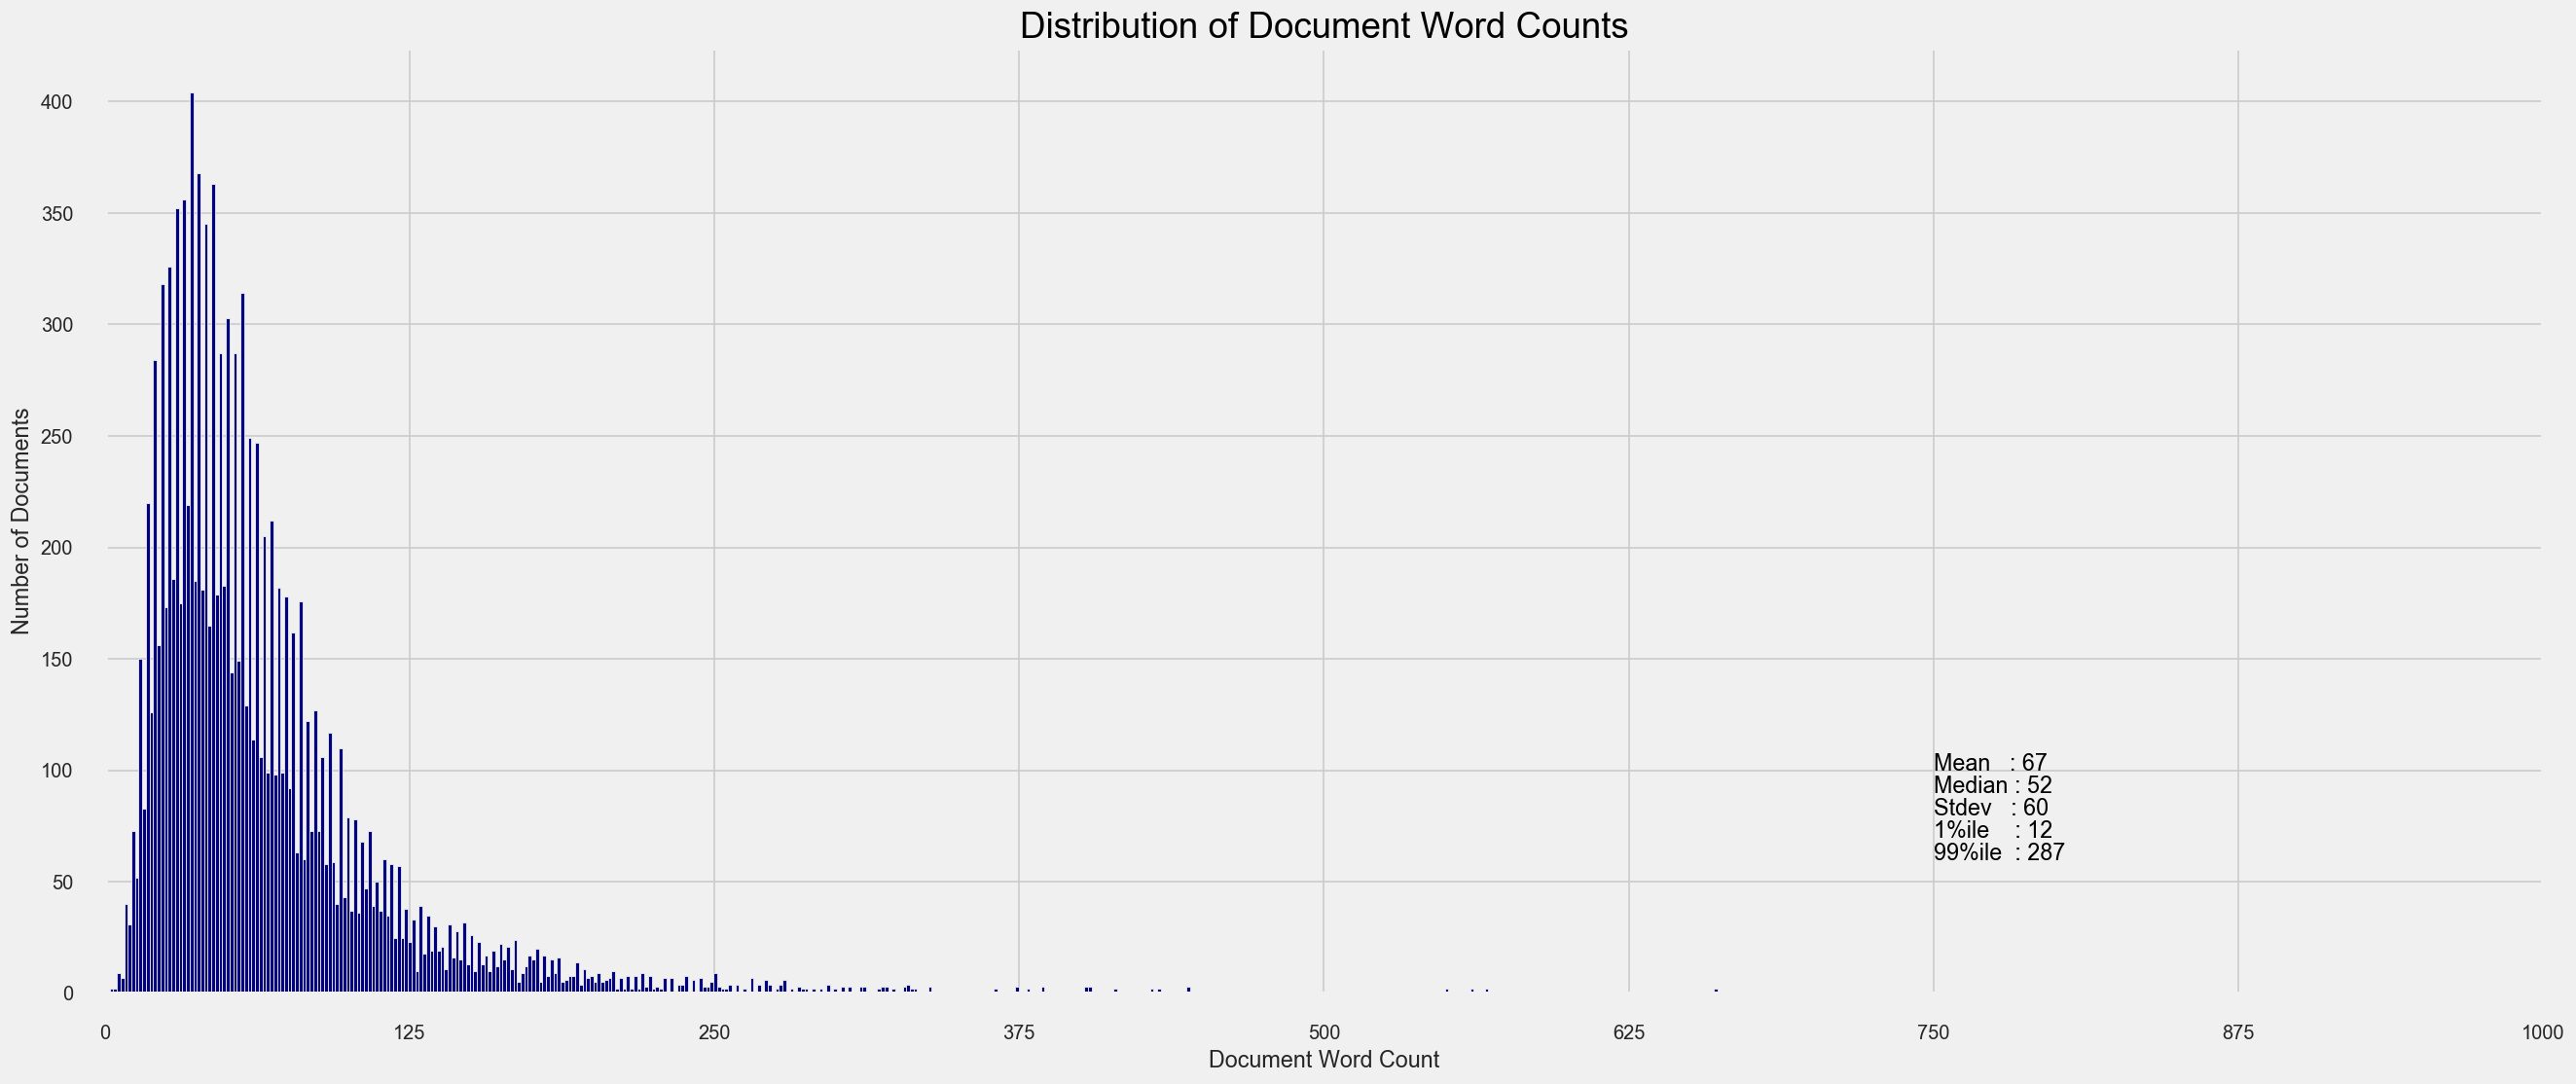

In [104]:


# Plot
plt.figure(figsize=(24,10), dpi=120)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()



In [107]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.052*"build" + 0.026*"use" + 0.025*"integration" + 0.022*"continuous" + '
  '0.018*"project" + 0.012*"code" + 0.011*"work" + 0.010*"way" + '
  '0.009*"change" + 0.009*"tool"'),
 (1,
  '0.048*"file" + 0.046*"build" + 0.031*"project" + 0.024*"server" + '
  '0.023*"use" + 0.016*"script" + 0.014*"msbuild" + 0.014*"setup" + '
  '0.012*"get" + 0.011*"add"'),
 (2,
  '0.106*"test" + 0.056*"run" + 0.049*"server" + 0.026*"unit" + 0.021*"fail" + '
  '0.016*"machine" + 0.013*"report" + 0.012*"start" + 0.012*"get" + '
  '0.012*"application"'),
 (3,
  '0.113*"teamcity" + 0.065*"plugin" + 0.060*"job" + 0.031*"platform" + '
  '0.021*"checkout" + 0.018*"java" + 0.016*"foo" + 0.015*"setup" + 0.014*"svn" '
  '+ 0.012*"findbug"')]


In [108]:


from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("lda_model")
lda_model.save(temp_file)



In [ ]:
# Load a potentially pretrained model from disk.
lda_model = lda_model.load(temp_file)

In [109]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.5053   
1            1             2.0              0.7750   
2            2             1.0              0.3640   
3            3             1.0              0.4845   
4            4             1.0              0.7573   
5            5             0.0              0.5027   
6            6             1.0              0.5810   
7            7             1.0              0.3912   
8            8             1.0              0.6049   
9            9             1.0              0.5884   

                                                                      Keywords  \
0  build, use, integration, continuous, project, code, work, way, change, tool   
1      test, run, server, unit, fail, machine, report, start, get, application   
2          file, build, project, server, use, script, msbuild, setup, get, add   
3          file, build, project, server, use, script, msbuild, setup, get, add   
4          file, build, project, server, use, script, msbuild, setup, get, add   
5  build, use, integration, continuous, project, code, work, way, change, tool   
6          file, build, project, server, use, script, msbuild, setup, get, add   
7          file, build, project, server, use, script, msbuild, setup, get, add   
8          file, build, project, server, use, script, msbuild, setup, get, add   
9          file, build, project, server, use, script, msbuild, setup, get, add   

                                                                                                  Text  
0  [change, pipeline, new, test, cypress, ci, idea, run, cypress, test, merge, know, change, url, t...  
1  [laravel, fail, assert, identical, try, make, ci, pipeline, run, phpunit, test, first, test, wor...  
2  [executor, installer, ci, job, interfere, installation, device, currently, sufficient, resource,...  
3  [job, ci, yml, base, different, runner, use, system, need, setup, runner, runner, window, powers...  
4  [build, godot, namespace, name, godot, find, build, godot, mono, project, clone, work, machine, ...  
5  [yml, file, ci, schedule, else, name, work, collaboration, people, github, yml, ci, run, night, ...  
6  [remove, object, file, pipeline, create, yaml, file, test, pipleline, build, code, generate, obj...  
7  [unable, pass, variable, downstream, pipeline, week, fight, pass, variable, job, get, lot, weird...  
8  [variable, jenkin, need, hide, value, jenkin, pipeline, create, library, class, handle, common, ...  
9  [enable, hot, reload, application, docker, use, docker, docker, compose, want, enable, hot, relo...

In [110]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(4)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9837   
1        1.0              0.9737   
2        2.0              0.9507   
3        3.0              0.6880   

                                                                      Keywords  \
0  build, use, integration, continuous, project, code, work, way, change, tool   
1          file, build, project, server, use, script, msbuild, setup, get, add   
2      test, run, server, unit, fail, machine, report, start, get, application   
3    teamcity, plugin, job, platform, checkout, java, foo, setup, svn, findbug   

                                                                                   Representative Text  
0  [jenkin, trigger, minute, last, build, recently, switch, jenkin, manage, build, trigger, new, bu...  
1  [building, maven, project, jenkin, new, jenkin, bear, project, build, correctly, run, mvn, insta...  
2  [goconvey, test, fail, error, code, run, goconvey, test, part, buildhow, make, sure, exit, error...  
3  [problem, code, code, work, infact, type, samethe, browser, work, replace, hostname, also, work,...

In [111]:


doc_lens = [len(d) for d in df_dominant_topic.Text]



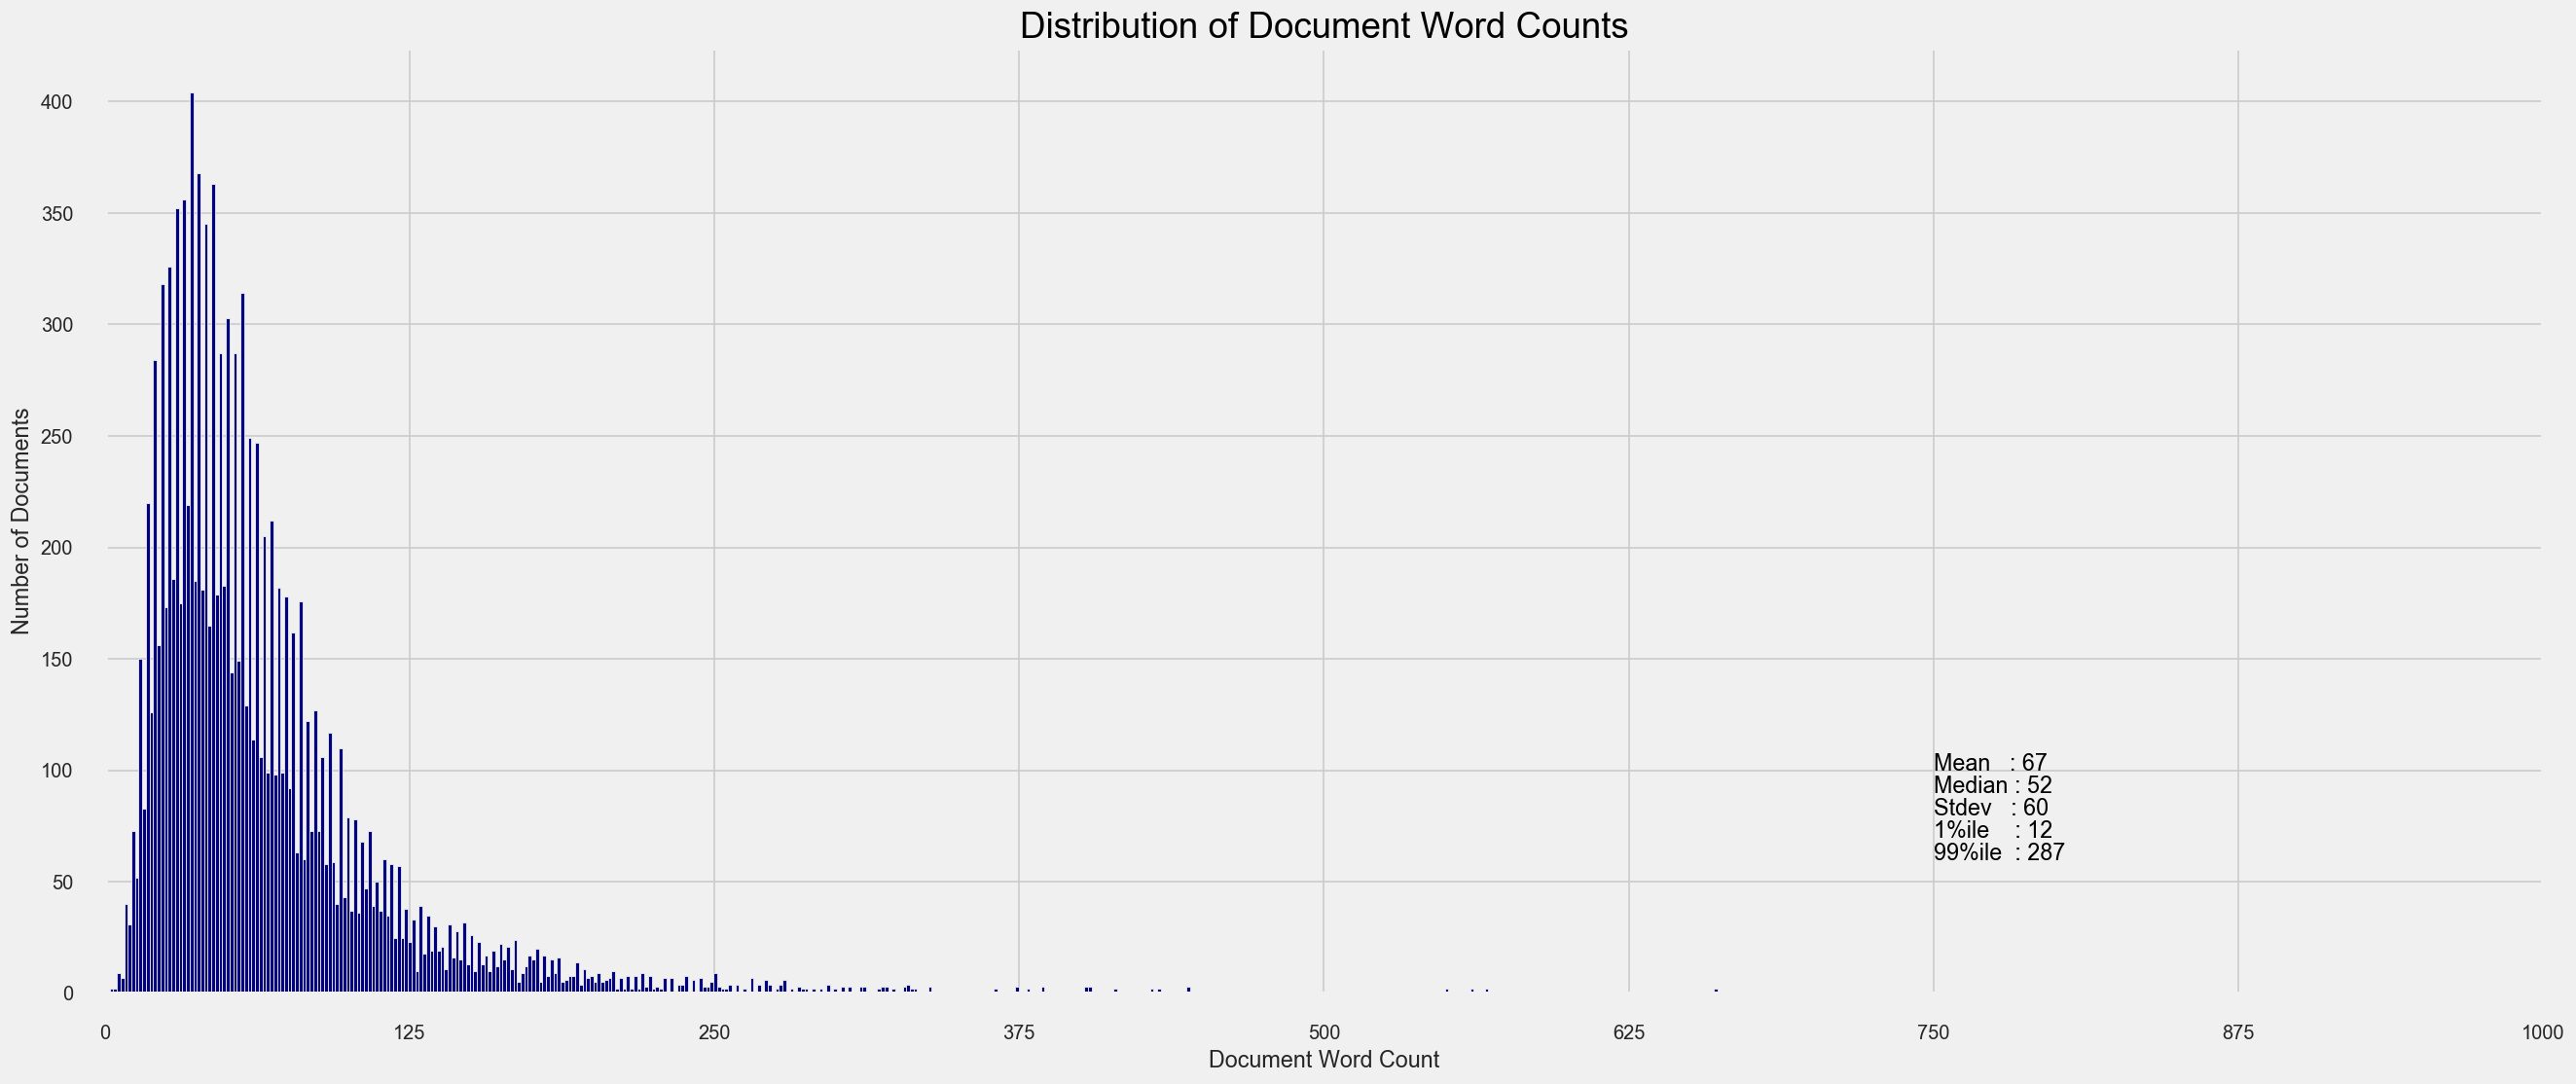

In [113]:


# Plot
plt.figure(figsize=(24,10), dpi=120)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()



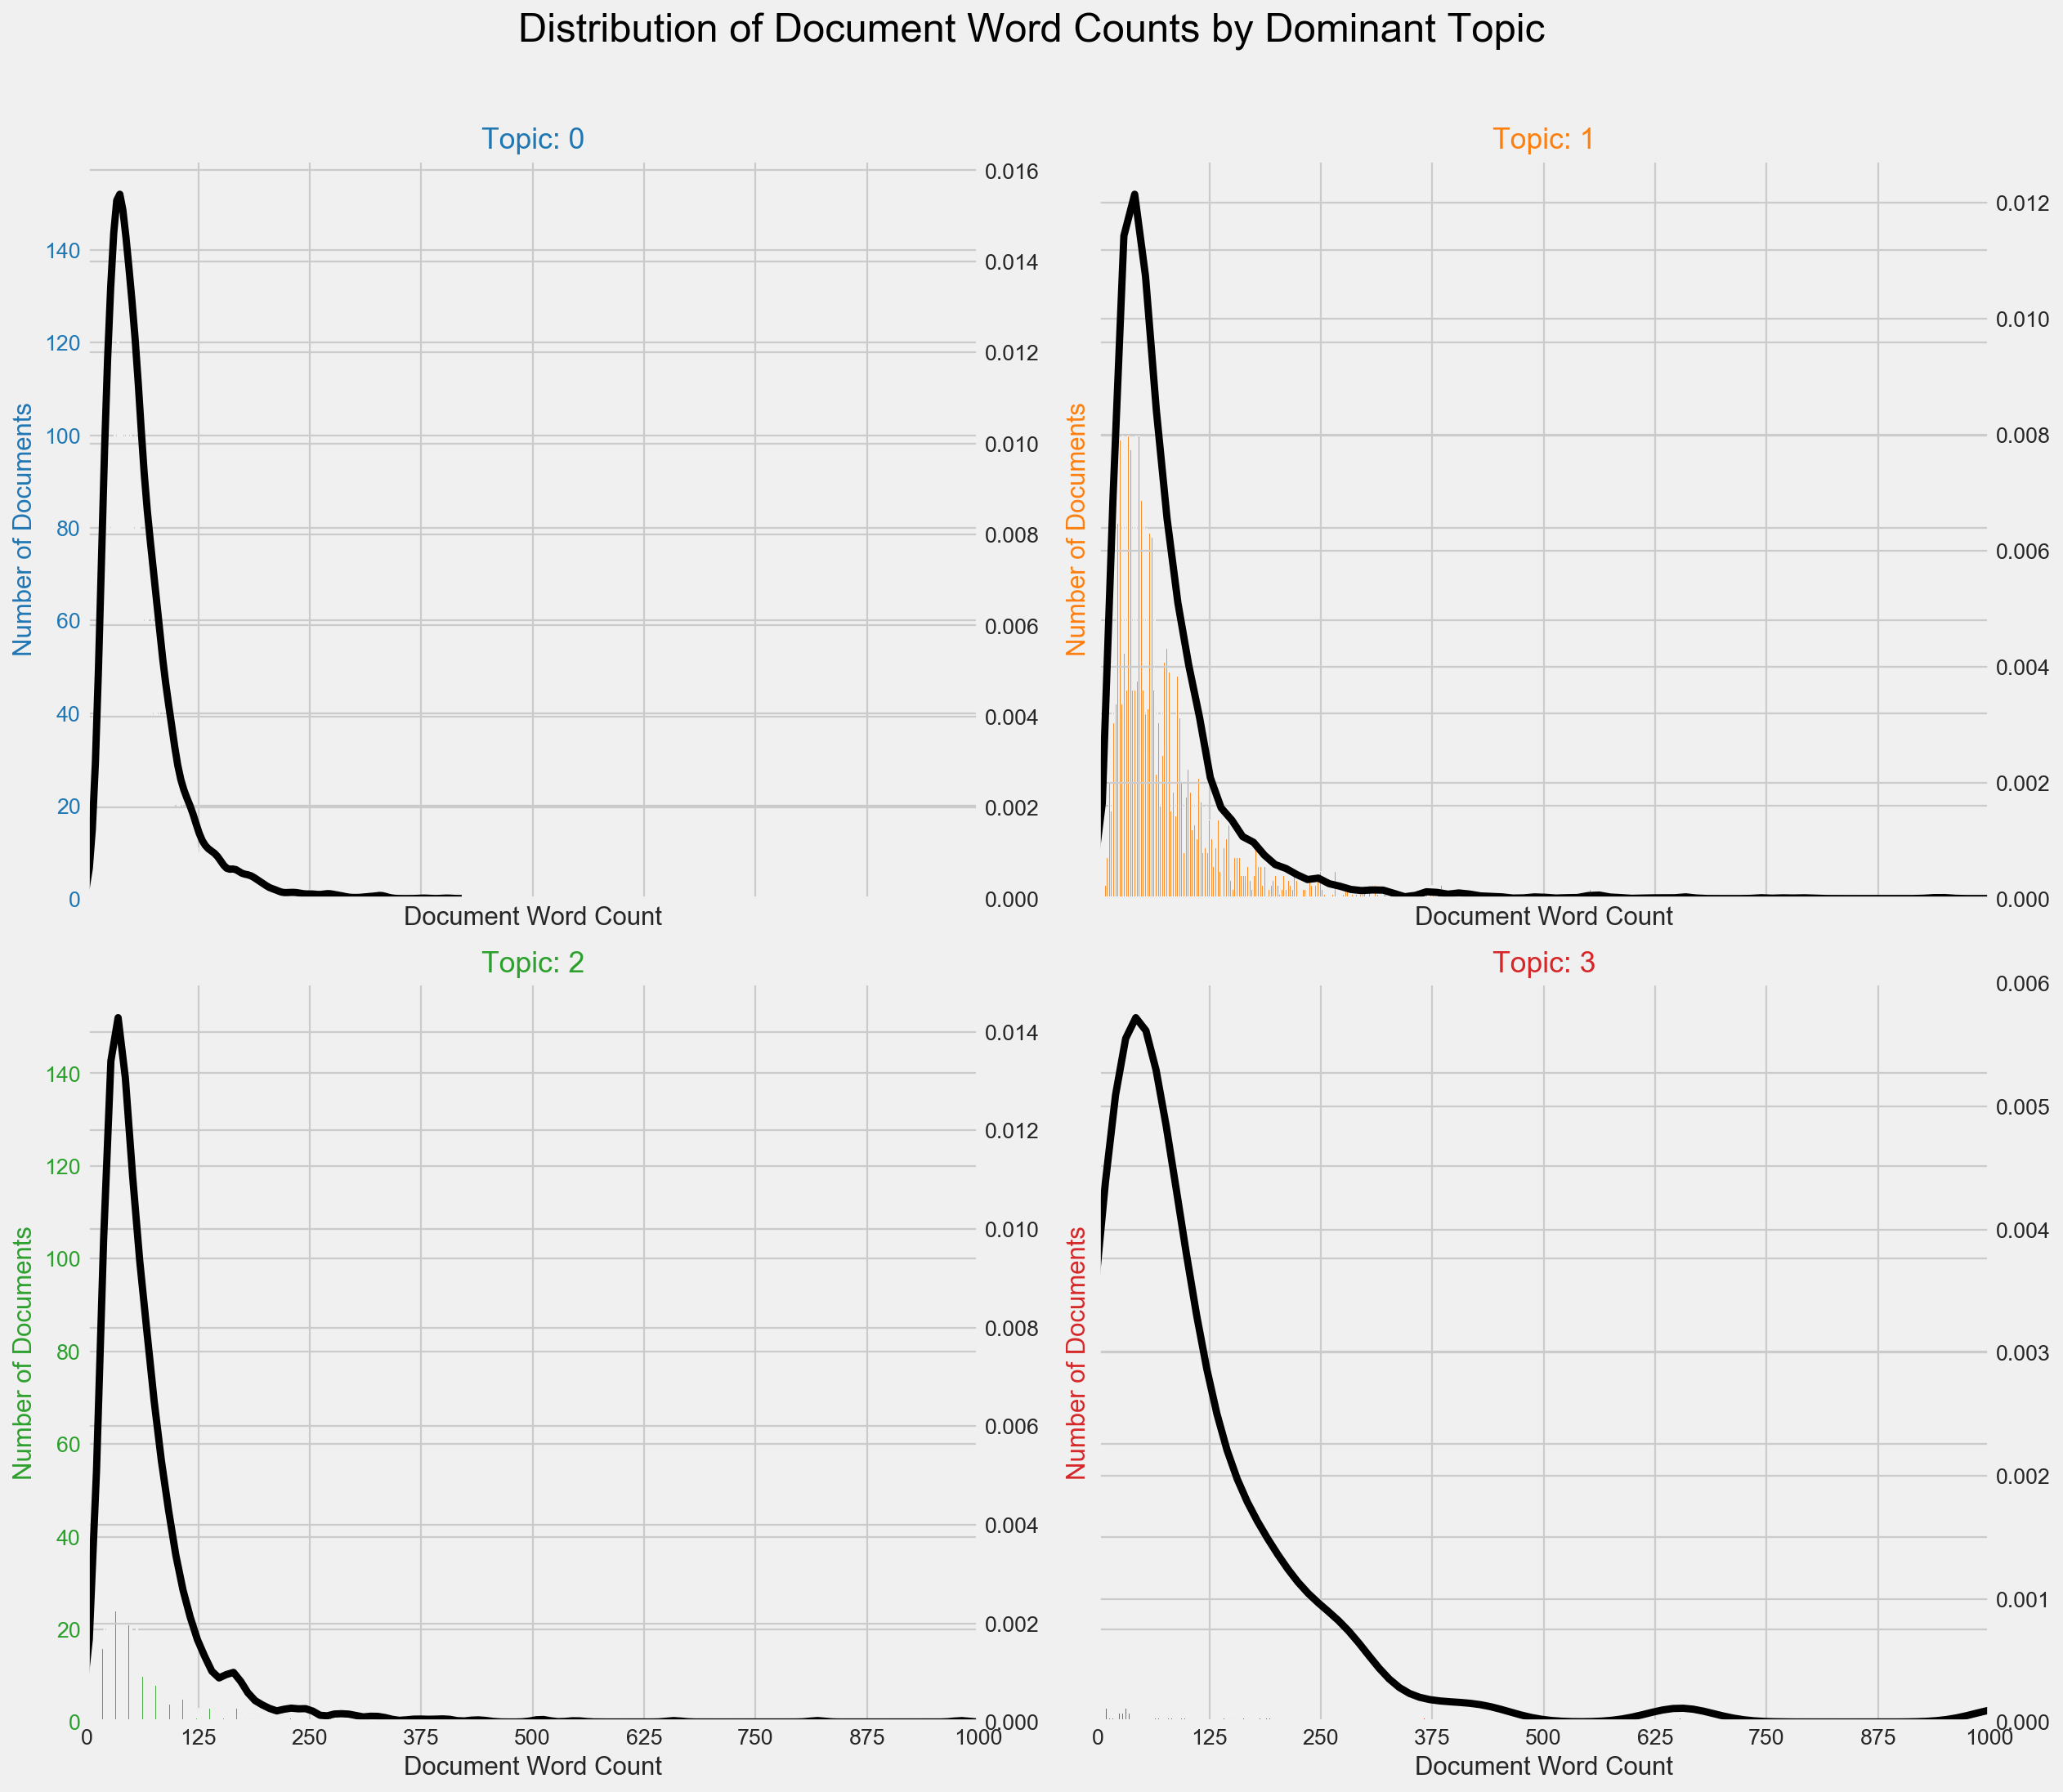

In [114]:


import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()



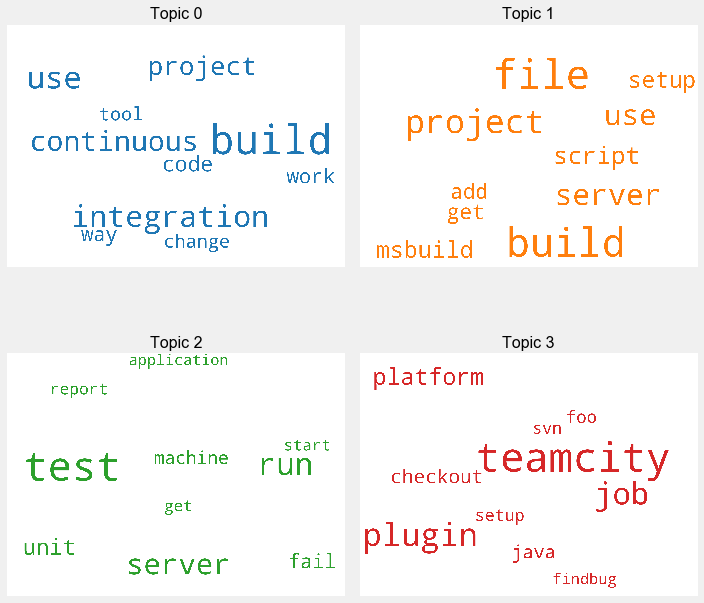

In [115]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

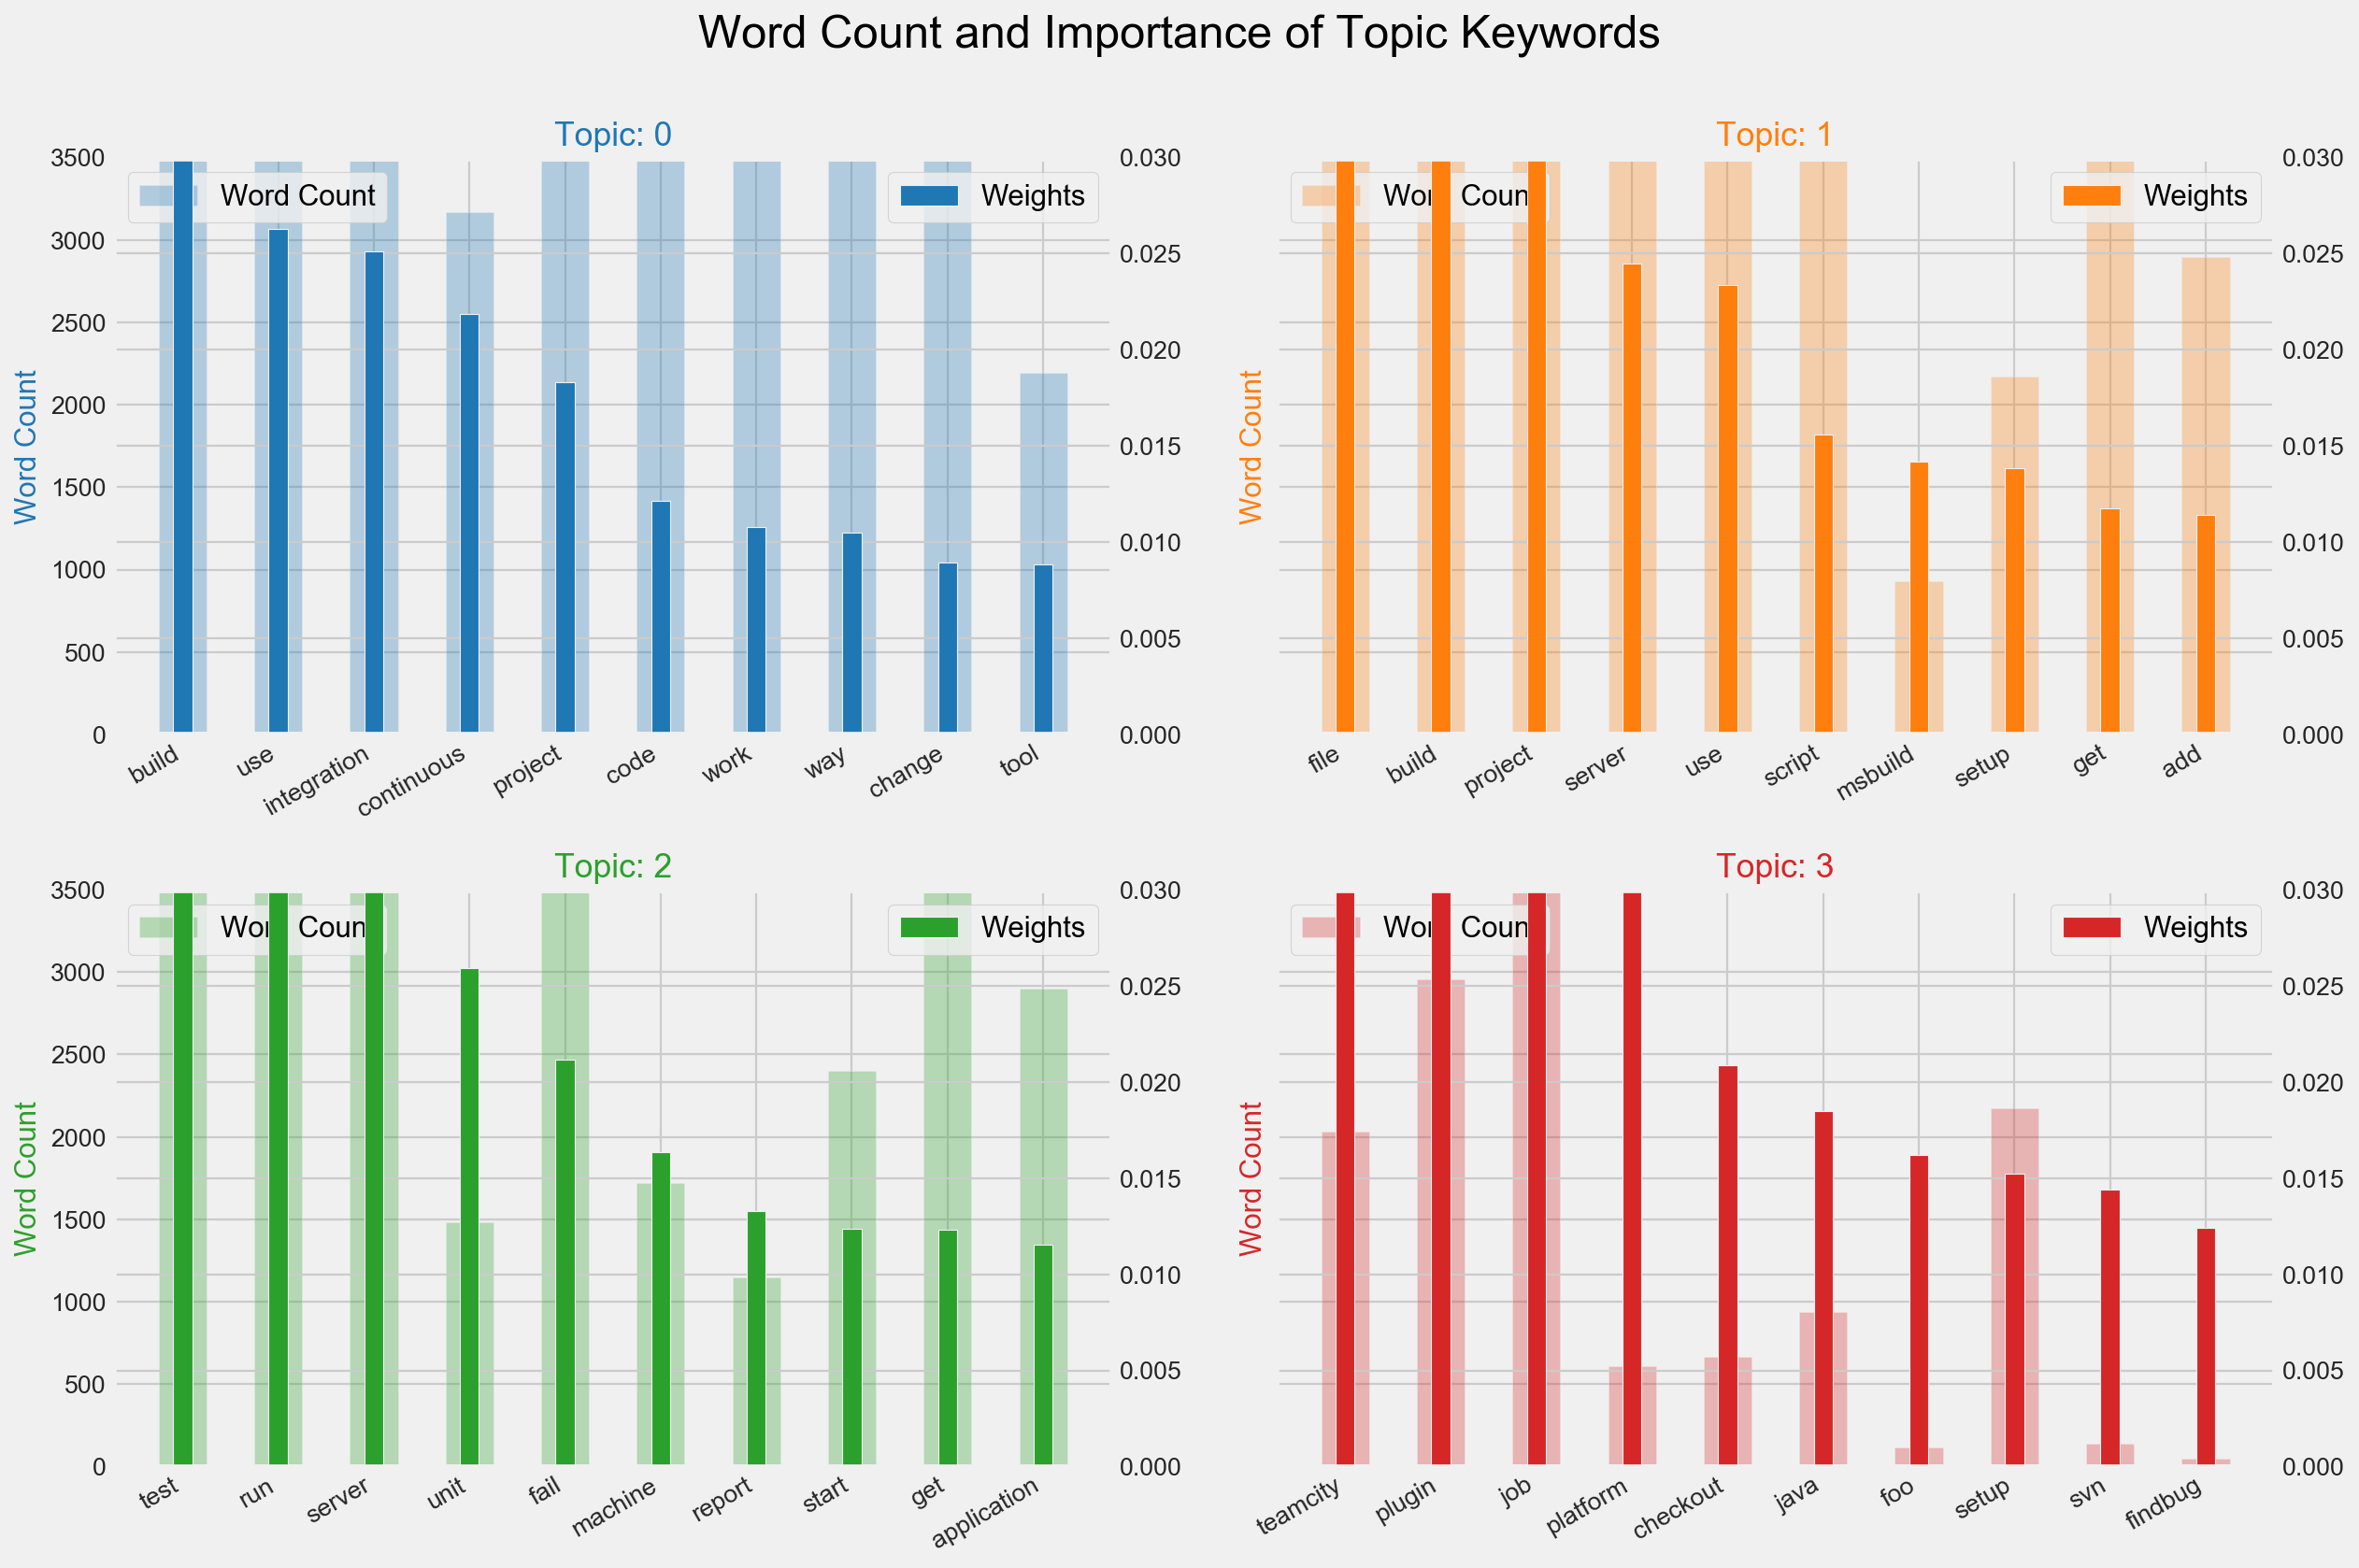

In [116]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

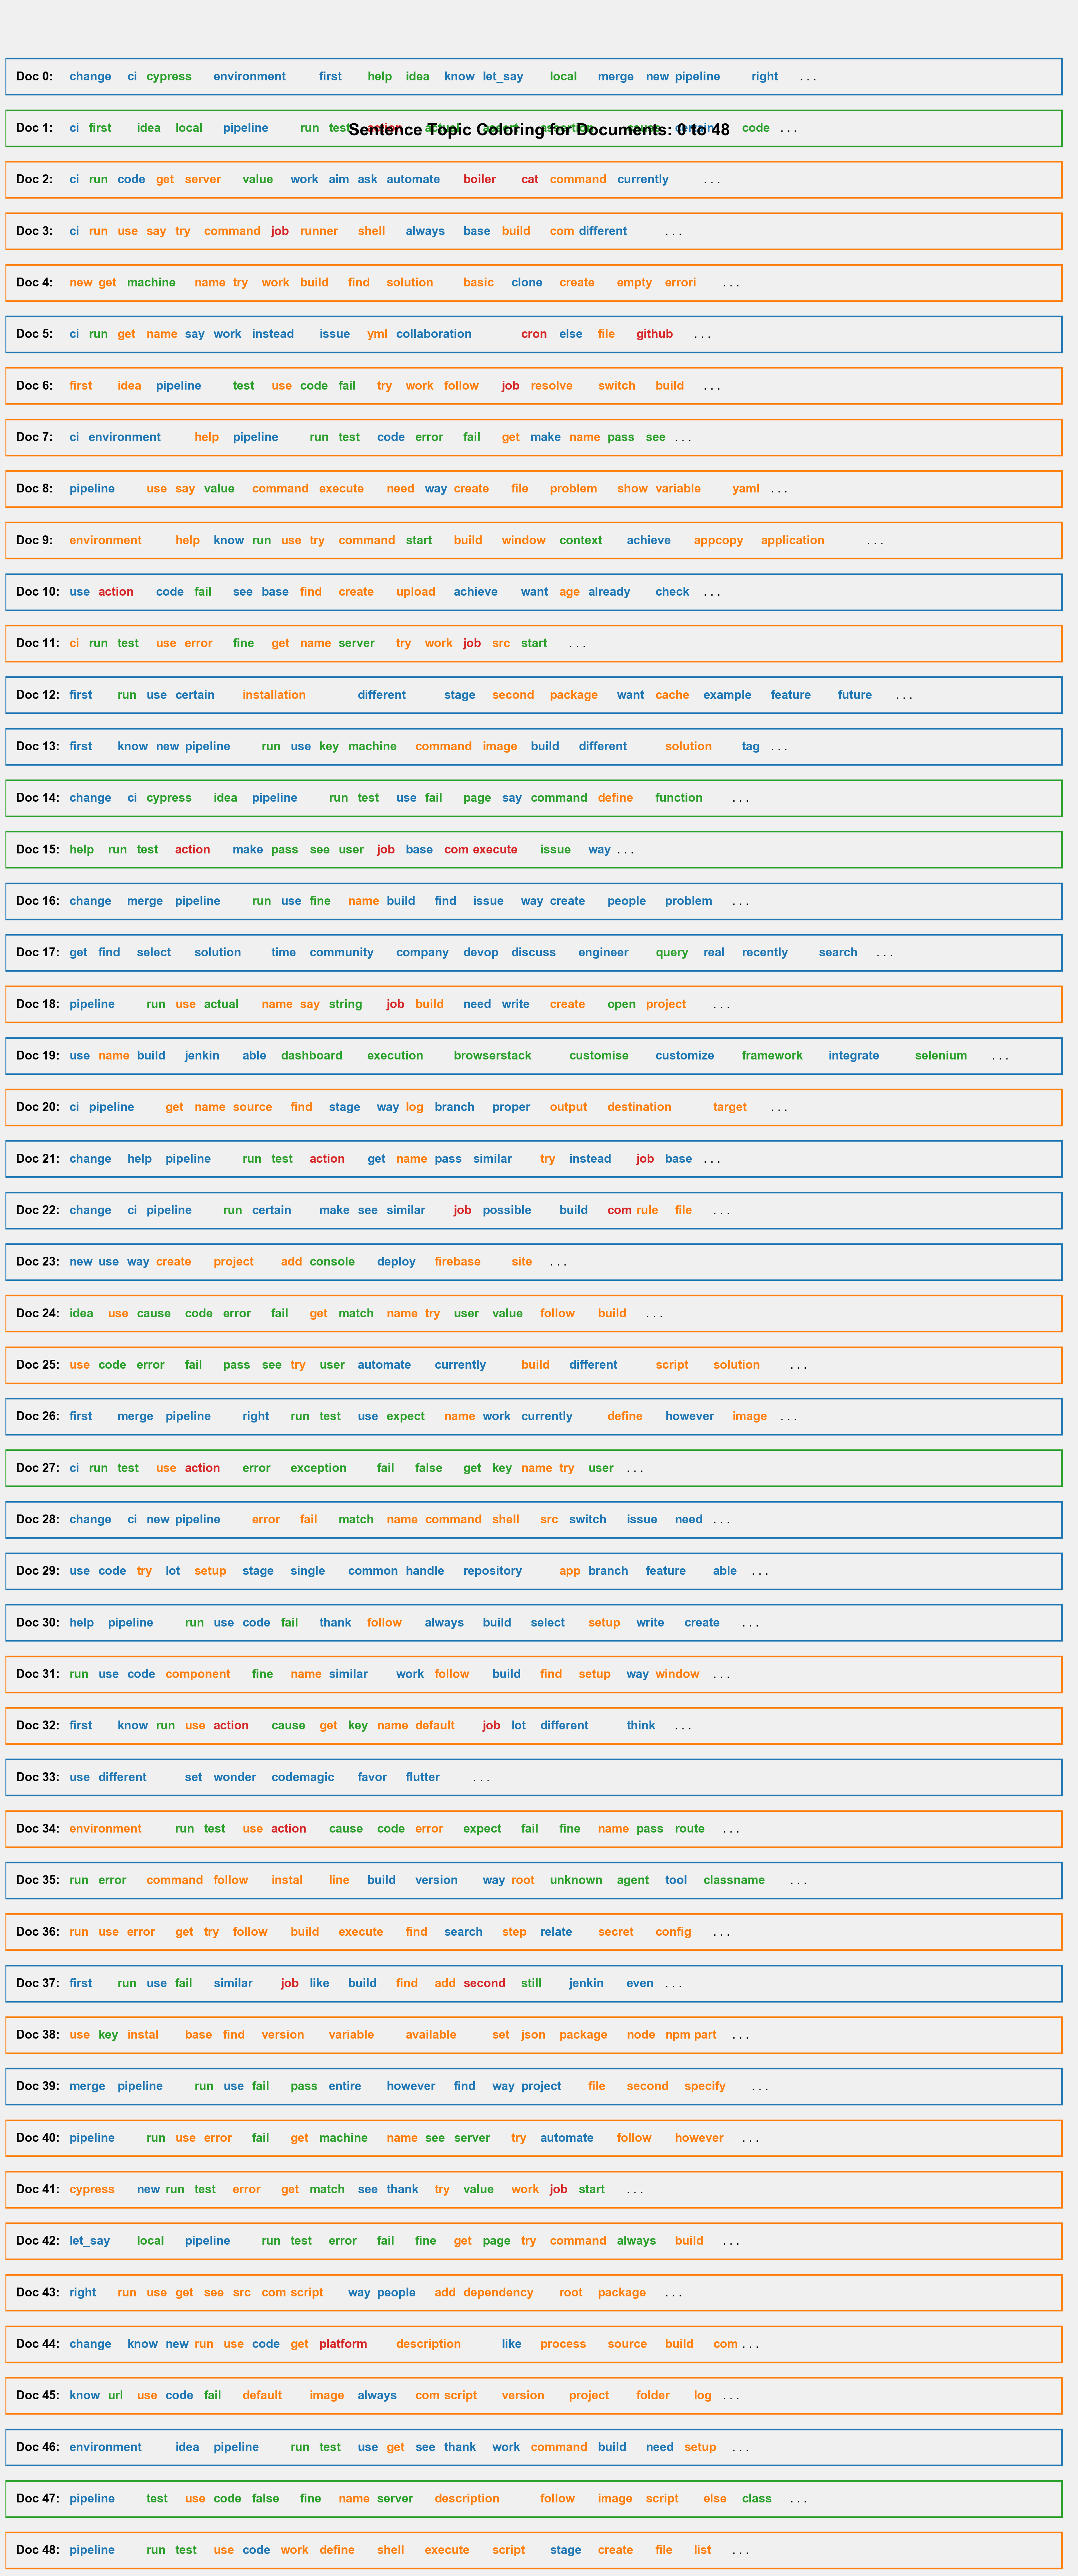

In [117]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 50):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [118]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [119]:


df_dominant_topic_in_each_doc.head()



Dominant_Topic  count
0               0   7048
1               1   3801
2               2   1683
3               3     95

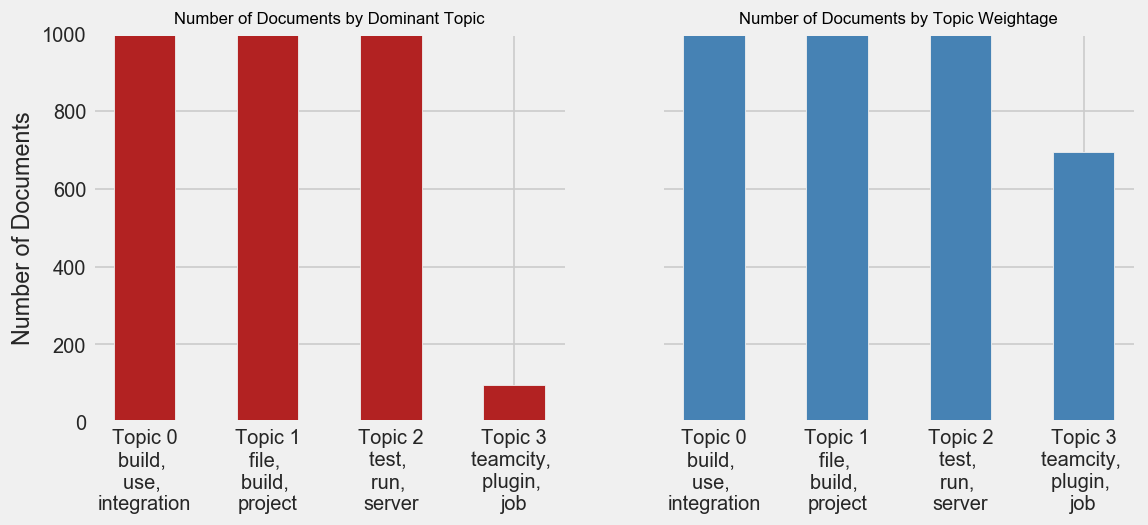

In [124]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

#Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))


plt.show()

In [125]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12298 samples in 0.049s...
[t-SNE] Computed neighbors for 12298 samples in 0.342s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12298
[t-SNE] Computed conditional probabilities for sample 2000 / 12298
[t-SNE] Computed conditional probabilities for sample 3000 / 12298
[t-SNE] Computed conditional probabilities for sample 4000 / 12298
[t-SNE] Computed conditional probabilities for sample 5000 / 12298
[t-SNE] Computed conditional probabilities for sample 6000 / 12298
[t-SNE] Computed conditional probabilities for sample 7000 / 12298
[t-SNE] Computed conditional probabilities for sample 8000 / 12298
[t-SNE] Computed conditional probabilities for sample 9000 / 12298
[t-SNE] Computed conditional probabilities for sample 10000 / 12298
[t-SNE] Computed conditional probabilities for sample 11000 / 12298
[t-SNE] Computed conditional probabilities for sample 12000 / 12298
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [128]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\11shr\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.238808 -0.160834       1        1  42.052583
1     -0.100366 -0.026015       2        1  31.395932
2     -0.012919  0.292614       3        1  20.501772
3      0.352094 -0.105765       4        1   6.049713, topic_info=          Term          Freq         Total Category  logprob  loglift
15        test  18366.000000  18366.000000  Default  30.0000  30.0000
771   teamcity   5744.000000   5744.000000  Default  29.0000  29.0000
166       file  12719.000000  12719.000000  Default  28.0000  28.0000
14         run  11893.000000  11893.000000  Default  27.0000  27.0000
56      server  15005.000000  15005.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
118        com    268.586680    797.485778   Topic4  -5.2449   1.7169
109     source    382.724900   3126.448589   Topic4  -4.8908   0.7048
6387    hudson    320.345326   2726.985761   Topic4  -5.0687   0.6636
111      start    269.223047   3099.077154   Topic4  -5.2426   0.3618
120    execute    222.079283   2026.256057   Topic4  -5.4351   0.5942

[230 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
315       1  0.036390  access
315       2  0.232339  access
315       3  0.730607  access
18        4  0.994815  action
177       2  0.999786     add
...     ...       ...     ...
148       3  0.542701  window
67        1  0.539088    work
67        2  0.279302    work
67        3  0.181582    work
604       4  0.991966   xcode

[279 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [129]:
def normalize_corpus_rn(corpus):
    
    normalized_corpus_rn = []
    
    # normalize each document in the corpus
    for doc in corpus:
        doc = doc.replace('rn', '')
        # Removing numbers
        doc = re.sub(r"\d+","",doc)
        normalized_corpus_rn.append(doc)
        
    return normalized_corpus_rn

In [131]:
df_experimenting = ques

In [132]:
print("Pre-processing the description field with use of Lemmatization")
df_experimenting["Full_Post_Cleaned_New"] = normalize_corpus_rn(ques["Full_Post_Cleaned"].tolist())

Pre-processing the description field with use of Lemmatization


C:\Users\11shr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
tickets = [ticket for ticket in df_experimenting.Full_Post_Cleaned_New]
# get tf-idf features 
ptvf = TfidfVectorizer(use_idf=True, min_df=0.05, max_df=0.95, ngram_range=(1,1), sublinear_tf=True)
ptvf_features = ptvf.fit_transform(tickets)
# view feature set dimensions
print(ptvf_features.shape)

(12628, 204)


In [134]:
import numpy as np


# prints components of all the topics 
# obtained from topic modeling
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=True,
                     num_terms=None):
    
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        topic = [(word, round(wt,2)) 
                 for word, wt in topic 
                 if abs(wt) >= weight_threshold]
                     
        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw
        print()
        

# extracts topics with their terms and weights
# format is Topic N: [(term1, weight1), ..., (termn, weightn)]        
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) 
                           for row 
                           in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) 
                               for wt, index 
                               in zip(weights,sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) 
                             for row 
                             in sorted_indices])
    
    topics = [np.vstack((terms.T, 
                     term_weights.T)).T 
              for terms, term_weights 
              in zip(sorted_terms, sorted_weights)]     
    
    return topics   

In [135]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import NMF

pyLDAvis.enable_notebook()
total_topics = 4

In [136]:
# build topic model on positive sentiment review features
nmf = NMF(n_components=total_topics, 
          random_state=42, alpha=0.1, l1_ratio=0.5)
nmf.fit(ptvf_features)      
# extract features and component weights
feature_names = ptvf.get_feature_names()
weights = nmf.components_
# extract and display topics and their components
topics = get_topics_terms_weights(weights, feature_names)
save_topics = print_topics_udf(topics=topics,
                 total_topics=total_topics,
                 num_terms=20,
                 display_weights=True)

Topic #1 with weights
[('test', 2.71), ('build', 2.64), ('integration', 2.55), ('project', 2.26), ('server', 2.24), ('continuous', 2.21), ('use', 2.13), ('would', 1.81), ('like', 1.55), ('run', 1.49), ('teamcity', 1.32), ('code', 1.23), ('tool', 1.22), ('way', 1.21), ('solution', 1.2), ('application', 1.18), ('work', 1.14), ('net', 1.13), ('ci', 1.09), ('file', 1.09)]

Topic #2 with weights
[('error', 2.75), ('gitlab', 2.74), ('ci', 2.2), ('docker', 2.2), ('run', 2.12), ('file', 2.06), ('fail', 1.75), ('try', 1.69), ('image', 1.68), ('script', 1.66), ('command', 1.66), ('get', 1.58), ('install', 1.49), ('yml', 1.36), ('test', 1.29), ('runner', 1.21), ('name', 1.2), ('stage', 1.2), ('pipeline', 1.18), ('app', 1.16)]

Topic #3 with weights
[('branch', 3.48), ('git', 2.26), ('github', 2.25), ('trigger', 1.98), ('push', 1.96), ('commit', 1.9), ('pipeline', 1.81), ('master', 1.64), ('repository', 1.62), ('change', 1.59), ('repo', 1.55), ('pull', 1.35), ('release', 1.23), ('request', 1.1), (

In [137]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['cypress', 'change', 'gitlab', 'ci', 'pipeline', 'new', 'test', 'cypress', 'gitlab', 'ci', 'idea', 'run', 'cypress', 'test', 'merge', 'know', 'change', 'url', 'test', 'run', 'pipeline', 'gitlab', 'let_say', 'first', 'test', 'local', 'environment', 'use', 'change', 'right', 'url', 'run', 'test', 'gitlab', 'ci', 'pipeline', 'help']


In [138]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [139]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['change', 'pipeline', 'new', 'test', 'cypress', 'ci', 'idea', 'run', 'cypress', 'test', 'merge', 'know', 'change', 'url', 'test', 'run', 'pipeline', 'let_say', 'first', 'test', 'local', 'environment', 'use', 'change', 'right', 'url', 'run', 'test', 'help']]


In [141]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])



[[(0, 3), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 3), (15, 5), (16, 2), (17, 1)]]


In [142]:
id2word[0]

'change'

In [143]:


# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]



[[('change', 3),
  ('ci', 1),
  ('cypress', 2),
  ('environment', 1),
  ('first', 1),
  ('help', 1),
  ('idea', 1),
  ('know', 1),
  ('let_say', 1),
  ('local', 1),
  ('merge', 1),
  ('new', 1),
  ('pipeline', 2),
  ('right', 1),
  ('run', 3),
  ('test', 5),
  ('url', 2),
  ('use', 1)]]

In [144]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [145]:


# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]



[(0,
  '0.249*"repository" + 0.079*"push" + 0.078*"git" + 0.053*"pull" + '
  '0.049*"develop" + 0.042*"resource" + 0.025*"suppose" + 0.024*"pipeline" + '
  '0.023*"interface" + 0.022*"tutorial"'),
 (1,
  '0.225*"branch" + 0.152*"trigger" + 0.142*"release" + 0.093*"feature" + '
  '0.064*"merge" + 0.050*"master" + 0.030*"exclude" + 0.018*"origin" + '
  '0.016*"filter" + 0.010*"change"'),
 (2,
  '0.045*"get" + 0.035*"set" + 0.027*"script" + 0.021*"try" + 0.015*"number" + '
  '0.015*"line" + 0.014*"work" + 0.014*"execute" + 0.014*"add" + '
  '0.013*"follow"'),
 (3,
  '0.380*"plugin" + 0.090*"info" + 0.076*"website" + 0.069*"jar" + '
  '0.067*"company" + 0.032*"monitor" + 0.029*"community" + 0.004*"engineer" + '
  '0.003*"poor" + 0.002*"clean"'),
 (4,
  '0.117*"build" + 0.055*"use" + 0.049*"project" + 0.035*"integration" + '
  '0.030*"continuous" + 0.022*"code" + 0.018*"way" + 0.016*"want" + '
  '0.016*"work" + 0.015*"change"'),
 (5,
  '0.154*"teamcity" + 0.138*"version" + 0.069*"control" +

In [147]:

from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Perplexity:  -11.12274704124354

Coherence Score:  0.36246521744659577


In [149]:


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis



C:\Users\11shr\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.338827 -0.036377       1        1  32.349313
2      0.313886  0.023402       2        1  18.754566
8      0.329769 -0.126652       3        1  13.794891
5      0.080512  0.210209       4        1   4.265779
9      0.045913  0.331383       5        1   4.242486
6      0.047613  0.006337       6        1   3.310639
15     0.124459 -0.187168       7        1   3.248076
0     -0.062017  0.014755       8        1   2.908501
12    -0.033222  0.011309       9        1   2.648231
7     -0.025167  0.024862      10        1   2.408274
1     -0.054103 -0.007104      11        1   2.129558
11    -0.048770  0.032300      12        1   2.129498
18    -0.085777 -0.038251      13        1   1.533469
10    -0.182669 -0.044429      14        1   1.354669
14    -0.095672 -0.023856      15        1   0.949467
13    -0.106231 -0.031757      16        1   0.916466
3     -0.115092 -0.032357      17        1   0.906818
19    -0.166796 -0.042227      18        1   0.850183
16    -0.152810 -0.042314      19        1   0.805961
17    -0.152654 -0.042064      20        1   0.493159, topic_info=         Term          Freq         Total Category  logprob  loglift
15       test  14717.000000  14717.000000  Default  30.0000  30.0000
166      file  11971.000000  11971.000000  Default  29.0000  29.0000
117     build  32791.000000  32791.000000  Default  28.0000  28.0000
14        run  14442.000000  14442.000000  Default  27.0000  27.0000
56     server  13946.000000  13946.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
6502   hudson      0.044036      1.563970  Topic20 -11.4689   1.7421
1979      bug      0.044032      1.563649  Topic20 -11.4690   1.7422
2526     edit      0.044032      1.563684  Topic20 -11.4689   1.7422
17847    nant      0.044033      1.563817  Topic20 -11.4689   1.7421
912       ant      0.044032      1.563846  Topic20 -11.4689   1.7421

[797 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1131      9  0.992718     accept
317       3  0.999223     access
18       13  0.996336     action
177       1  0.200243        add
177       2  0.717835        add
...     ...       ...        ...
607      12  0.996843      xcode
1476     12  0.998883        xml
1519      8  0.981253  yesterday
150      10  0.986632        yml
900       5  0.996235        zip

[658 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 9, 6, 10, 7, 16, 1, 13, 8, 2, 12, 19, 11, 15, 14, 4, 20, 17, 18])